In [ ]:
# %%capture
# # ! pip install datasets transformers

## Data Loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import os
# os.chdir("/content/drive/MyDrive/")

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

## Loading ViT Feature Extractor

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [ ]:
# from transformers import ViTFeatureExtractor

# model_name_or_path = 'google/vit-base-patch16-224-in21k'
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path, do_normalize=False, do_rescale=False)

If we print a feature extractor, we can see its configuration.

In [ ]:
# feature_extractor

## Image Preprocessing

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path, do_normalize=False, do_rescale=False)

In [ ]:
#load images
train_images = np.load('drive/MyDrive/CSE547/train_images_small.npz')
val_images = np.load('drive/MyDrive/CSE547/val_images_small.npz')
test_images = np.load('drive/MyDrive/CSE547/test_images_small.npz')

train_images = [train_images[key] for key in train_images.files]
train_images = np.array(train_images)
train_images=train_images.reshape(9960,256,256)

val_images = [val_images[key] for key in val_images.files]
val_images = np.array(val_images)
val_images=val_images.reshape(2134,256,256)

test_images = [test_images[key] for key in test_images.files]
test_images = np.array(test_images)
test_images=test_images.reshape(2137,256,256)


train_images = train_images - np.min(train_images)
train_images = train_images / np.max(train_images)
train_images = train_images * 255
train_images = train_images.astype(np.uint8)
train_images = train_images.reshape(9960, 256, 256)

val_images = val_images - np.min(val_images)
val_images = val_images / np.max(val_images)
val_images = val_images * 255
val_images = val_images.astype(np.uint8)
val_images = val_images.reshape(2134, 256, 256)

test_images = test_images - np.min(test_images)
test_images = test_images / np.max(test_images)
test_images = test_images * 255
test_images = test_images.astype(np.uint8)
test_images = test_images.reshape(2137, 256, 256)

train_images=np.stack((train_images,) * 3, axis=-1)
val_images=np.stack((val_images,) * 3, axis=-1)
test_images=np.stack((test_images,) * 3, axis=-1)


In [ ]:
#train_indices = np.random.choice(len(val_images), 9961, replace=False)
#train_images = train_images[train_indices]
#val_indices = np.random.choice(len(val_images), 2134, replace=False)
#val_images = val_images[val_indices]
#test_indices = np.random.choice(len(test_images), 2135, replace=False)
#test_images=test_images[test_indices]


train_images = feature_extractor(train_images, return_tensors='pt')
val_images = feature_extractor(val_images, return_tensors='pt')
test_images = feature_extractor(test_images, return_tensors='pt')

train_images = train_images['pixel_values']
val_images = val_images['pixel_values']
test_images = test_images['pixel_values']

train_labels = pd.read_csv('drive/MyDrive/CSE547/train_labels_small.csv')
val_labels = pd.read_csv('drive/MyDrive/CSE547/val_labels_small.csv')
test_labels = pd.read_csv('drive/MyDrive/CSE547/test_labels_small.csv')


from sklearn.preprocessing import LabelEncoder
classes=train_labels['class']
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(classes)

classes=val_labels['class']
label_encoder = LabelEncoder()
val_labels = label_encoder.fit_transform(classes)

classes=test_labels['class']
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(classes)


#train_labels = train_labels[train_indices]
#val_labels = val_labels[val_indices]
#test_labels = test_labels[test_indices]

# Combine back into dictionaries
inputs_train = {
    'pixel_values': train_images,
    'label': train_labels
}

inputs_val = {
    'pixel_values': val_images,
    'label': val_labels
}

inputs_test = {
    'pixel_values': test_images,
    'label': test_labels
}

In [ ]:
inputs_train['pixel_values'].shape

torch.Size([9960, 3, 224, 224])

In [ ]:
inputs_train['label'].shape

(9960,)

In [ ]:
def reshape_images(images):
    reshaped_images = np.transpose(images, (0, 2, 3, 1))  # Reorder dimensions
    return reshaped_images

train_images = reshape_images(train_images)
val_images = reshape_images(val_images)
test_images = reshape_images(test_images)

In [ ]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(9960,)
(2134,)
(2137,)
torch.Size([9960, 224, 224, 3])
torch.Size([2134, 224, 224, 3])
torch.Size([2137, 224, 224, 3])


## Model

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=4
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as plt
import io

# Train

In [ ]:
import torch
from torch import tensor
from torch.utils.data import DataLoader,TensorDataset,SequentialSampler,RandomSampler
import numpy as np
from sklearn.model_selection import train_test_split

# Convert inputs to PyTorch tensors
inputs_train['pixel_values'] = torch.tensor(inputs_train['pixel_values'])
inputs_train['label'] = torch.tensor(inputs_train['label'])

trainDataset = TensorDataset(inputs_train['pixel_values'], inputs_train['label'])
trainDataLoader = DataLoader(trainDataset, batch_size=8)

<ipython-input-24-5bba705a07a7>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_train['pixel_values'] = torch.tensor(inputs_train['pixel_values'])


In [ ]:
def train_loop(model, train_dataloader, lossfunc, optimizer, scheduler):
    model = model.to("cuda")
    model.train()
    loop_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, batch in enumerate(train_dataloader):
        step_img, step_label = batch
        step_img, step_label = step_img.to("cuda"), step_label.to("cuda")

        optimizer.zero_grad()
        outputs = model(step_img)
        logits = outputs.logits
        loss = lossfunc(logits, step_label)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        loop_loss += float(loss.to("cpu"))

        # Calculate predictions and accuracy
        _, predicted_labels = torch.max(logits, 1)
        correct_preds += (predicted_labels == step_label).sum().item()
        total_preds += step_label.size(0)


        if step%100 == 0:
            print("step " + str(step) + " loss: " + str(float(loss.to("cpu"))))

        torch.cuda.empty_cache()

    with torch.no_grad():
        # Calculate loop accuracy
        loop_acc = correct_preds / total_preds
        avg_loss = loop_loss / len(train_dataloader)

        return avg_loss, loop_acc

In [ ]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.preprocessing import label_binarize
from keras.utils import to_categorical

In [ ]:
def test_loop(model, val_img, val_label, writer, epoch):
    model.eval()
    model = model.to("cuda")

    # Ensure inputs are tensors
    val_img = torch.tensor(val_img).to("cuda")
    val_label = torch.tensor(val_label).to("cuda")

    with torch.no_grad():
        step_img, step_label = val_img.to("cuda"), val_label.to("cuda")

        outputs = model(step_img)
        logits = outputs.logits
        loss = criterion(logits, step_label)
        logits = logits.to("cpu")
        predicted_labels = torch.argmax(logits, axis=1)
        cm = confusion_matrix(val_label.cpu(), predicted_labels)

        fig, ax = plot_confusion_matrix(conf_mat=cm)
        writer.add_figure(tag='test evaluate', figure=fig, global_step=epoch)
        val_label_one_hot = label_binarize(val_label.cpu(), classes=[i for i in range(logits.shape[1])])

        # auroc = roc_auc_score(val_label_one_hot, logits, multi_class='ovr')
        val_acc = accuracy_score(val_label.cpu(), predicted_labels)
        #precision = precision_score(val_label.cpu(), predicted_labels, average='weighted')
        #recall = recall_score(val_label.cpu(), predicted_labels, average='weighted')
        #f2_score = fbeta_score(val_label.cpu(), predicted_labels, beta=2, average='weighted')

    return val_acc, loss.item()
    #, precision, recall, f2_score  # Return precision, recall, and F2 score


In [ ]:
# def test_loop(model, val_img, val_label, writer, epoch):
#     model.eval()
#     model = model.to("cuda")
#     with torch.no_grad():
#         label= to_categorical(val_label)
#         step_img,step_label = val_img.to("cuda"), torch.Tensor(label).to("cuda")
#         outputs = model(step_img, labels=step_label)
#         logits = outputs.logits
#         loss = outputs.loss
#     logits = logits.to("cpu")
#     predicted_labels = np.argmax(logits, axis=1)
#     cm = confusion_matrix(val_label,predicted_labels)
#     fig, ax = plot_confusion_matrix(conf_mat=cm)
#     writer.add_figure(tag='test evaluate', figure=fig, global_step=epoch)

#     # Convert labels to one-hot
#     val_label_one_hot = label_binarize(val_label, classes=[i for i in range(logits.shape[1])])

#     return roc_auc_score(val_label_one_hot,logits, multi_class='ovr'), accuracy_score(val_label, predicted_labels), loss

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, min_lr=0.000001)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import time
import os

version = "v1"
log_dir = os.path.join("runs", version, 'ViT')
writer = SummaryWriter(log_dir)
# data_path = "drive/MyDrive/CSE547/"
data_path = "/content/drive/MyDrive/CSE547/"


start_time = time.time()
for epoch in range(30):
    print("--"*20)
    print("epoch: " + str(epoch))
    time0 = time.time()

    avgloss, train_acc = train_loop(model, trainDataLoader, criterion, optimizer, scheduler)
    val_acc, val_loss = test_loop(model, inputs_val['pixel_values'], inputs_val['label'], writer, epoch)

    # writer.add_scalar("test time", time.time()-time0, epoch)
    writer.add_scalar('train loss', avgloss , epoch)
    writer.add_scalar('train accuracy', train_acc , epoch)
    # writer.add_scalar('val auroc', auroc , epoch)

    writer.add_scalar('val loss', val_loss , epoch)
    writer.add_scalar('validation accuracy', val_acc , epoch)
    writer.add_scalar('current lr', optimizer.param_groups[0]['lr'], epoch)

    print(f"Train Loss: {avgloss}, Train Accuracy: {train_acc}")
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    # print("accuracy: " + str(val_acc) + "\t auroc:" + str(auroc))
    # print("use time: " + str(time.time() - time0))

    model.eval()
    if (epoch+1) % 20 == 0:
        torch.save({'state_dict': model.state_dict()}, data_path + 'vit/' + str(version) + "e" + str(epoch+1) + '.pth.tar')
    else:
        torch.save({'state_dict': model.state_dict()}, data_path + "vit/quicksave.pth.tar")

end_time = time.time()
print("Training Time:", end_time - start_time)

----------------------------------------
epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


step 0 loss: 1.376747488975525
step 100 loss: 0.022947242483496666
step 200 loss: 0.009852984920144081
step 300 loss: 0.0056175244972109795
step 400 loss: 0.06652256101369858
step 500 loss: 0.022390712052583694
step 600 loss: 0.0209868922829628
step 700 loss: 0.020871715620160103
step 800 loss: 2.6113784313201904
step 900 loss: 0.41914162039756775
step 1000 loss: 0.2702019512653351
step 1100 loss: 0.567835807800293
step 1200 loss: 0.24215608835220337


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.46160565536192444, Train Accuracy: 0.8570281124497992
Validation Loss: 2.463904857635498, Validation Accuracy: 0.1836925960637301
----------------------------------------
epoch: 1
step 0 loss: 3.2327992916107178
step 100 loss: 0.5784981846809387
step 200 loss: 0.0743197575211525
step 300 loss: 0.46857574582099915
step 400 loss: 0.3988092541694641
step 500 loss: 0.06458516418933868
step 600 loss: 0.04547148197889328
step 700 loss: 0.043122485280036926
step 800 loss: 0.7118462324142456
step 900 loss: 0.20822101831436157
step 1000 loss: 0.20472493767738342
step 1100 loss: 0.3998625576496124
step 1200 loss: 0.22088627517223358


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.3443249580611187, Train Accuracy: 0.9126506024096386
Validation Loss: 2.446274757385254, Validation Accuracy: 0.18791002811621368
----------------------------------------
epoch: 2
step 0 loss: 3.0922369956970215
step 100 loss: 0.3999265432357788
step 200 loss: 0.046617742627859116
step 300 loss: 0.30054667592048645
step 400 loss: 0.4435831904411316
step 500 loss: 0.08303134888410568
step 600 loss: 0.054298870265483856
step 700 loss: 0.0503416582942009
step 800 loss: 0.25932741165161133
step 900 loss: 0.1563071757555008
step 1000 loss: 0.16246922314167023
step 1100 loss: 0.24675536155700684
step 1200 loss: 0.15932413935661316


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.2566674217581749, Train Accuracy: 0.9448795180722892
Validation Loss: 2.609869956970215, Validation Accuracy: 0.18744142455482662
----------------------------------------
epoch: 3
step 0 loss: 3.2432992458343506
step 100 loss: 0.23999646306037903
step 200 loss: 0.04162359610199928
step 300 loss: 0.18340818583965302
step 400 loss: 0.3605821132659912
step 500 loss: 0.07736033946275711
step 600 loss: 0.053863491863012314
step 700 loss: 0.050810277462005615
step 800 loss: 0.22627946734428406
step 900 loss: 0.13924510776996613
step 1000 loss: 0.1397324651479721
step 1100 loss: 0.20644749701023102
step 1200 loss: 0.13700132071971893


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.21574842978164135, Train Accuracy: 0.9576305220883534
Validation Loss: 2.6977241039276123, Validation Accuracy: 0.18791002811621368
----------------------------------------
epoch: 4
step 0 loss: 3.363745927810669
step 100 loss: 0.17639875411987305
step 200 loss: 0.03902415558695793
step 300 loss: 0.14464998245239258
step 400 loss: 0.20630230009555817
step 500 loss: 0.07285111397504807
step 600 loss: 0.05153205618262291
step 700 loss: 0.051983799785375595
step 800 loss: 0.19136838614940643
step 900 loss: 0.12486322224140167
step 1000 loss: 0.12547609210014343
step 1100 loss: 0.19810496270656586
step 1200 loss: 0.144622802734375


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20455981724592576, Train Accuracy: 0.9605421686746988
Validation Loss: 2.7343599796295166, Validation Accuracy: 0.18791002811621368
----------------------------------------
epoch: 5
step 0 loss: 3.380450487136841
step 100 loss: 0.1371936798095703
step 200 loss: 0.035367630422115326
step 300 loss: 0.1099749282002449
step 400 loss: 0.12783347070217133
step 500 loss: 0.0640360414981842
step 600 loss: 0.04649770259857178
step 700 loss: 0.04670647904276848
step 800 loss: 0.188046395778656
step 900 loss: 0.12044987827539444
step 1000 loss: 0.11531685292720795
step 1100 loss: 0.16436836123466492
step 1200 loss: 0.1174590140581131


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20437768438165207, Train Accuracy: 0.9575301204819278
Validation Loss: 2.813800811767578, Validation Accuracy: 0.18697282099343954
----------------------------------------
epoch: 6
step 0 loss: 3.506277084350586
step 100 loss: 0.11575063318014145
step 200 loss: 0.03273189440369606
step 300 loss: 0.10115996748209
step 400 loss: 0.1543184220790863
step 500 loss: 0.05928287282586098
step 600 loss: 0.044497549533843994
step 700 loss: 0.04571354389190674
step 800 loss: 0.1810639351606369
step 900 loss: 0.11463388800621033
step 1000 loss: 0.10980398952960968
step 1100 loss: 0.16273289918899536
step 1200 loss: 0.11148746311664581


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20040506304327743, Train Accuracy: 0.9586345381526105
Validation Loss: 2.8293051719665527, Validation Accuracy: 0.18650421743205248
----------------------------------------
epoch: 7
step 0 loss: 3.467379570007324
step 100 loss: 0.09589870274066925
step 200 loss: 0.028928065672516823
step 300 loss: 0.09220654517412186
step 400 loss: 0.1161673292517662
step 500 loss: 0.062183938920497894
step 600 loss: 0.04518347606062889
step 700 loss: 0.047206297516822815
step 800 loss: 0.19844676554203033
step 900 loss: 0.11390829086303711
step 1000 loss: 0.10612324625253677
step 1100 loss: 0.15115346014499664
step 1200 loss: 0.10405033826828003


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20044614559406018, Train Accuracy: 0.9579317269076305
Validation Loss: 2.868077039718628, Validation Accuracy: 0.1893158388003749
----------------------------------------
epoch: 8
step 0 loss: 3.5065019130706787
step 100 loss: 0.12604258954524994
step 200 loss: 0.028170347213745117
step 300 loss: 0.09728434681892395
step 400 loss: 0.15750277042388916
step 500 loss: 0.06478315591812134
step 600 loss: 0.04747805744409561
step 700 loss: 0.04711092263460159
step 800 loss: 0.17387384176254272
step 900 loss: 0.10626902431249619
step 1000 loss: 0.10403952747583389
step 1100 loss: 0.14951302111148834
step 1200 loss: 0.09760026633739471


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.2007188156277061, Train Accuracy: 0.957429718875502
Validation Loss: 2.944589138031006, Validation Accuracy: 0.1888472352389878
----------------------------------------
epoch: 9
step 0 loss: 3.5843393802642822
step 100 loss: 0.09843840450048447
step 200 loss: 0.028754692524671555
step 300 loss: 0.0880727469921112
step 400 loss: 0.1595047265291214
step 500 loss: 0.058024562895298004
step 600 loss: 0.0441511832177639
step 700 loss: 0.04450505971908569
step 800 loss: 0.16361168026924133
step 900 loss: 0.1071482002735138
step 1000 loss: 0.1030728667974472
step 1100 loss: 0.18049338459968567
step 1200 loss: 0.09385158121585846


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20054086193621876, Train Accuracy: 0.9569277108433735
Validation Loss: 2.9482581615448, Validation Accuracy: 0.19072164948453607
----------------------------------------
epoch: 10
step 0 loss: 3.6405460834503174
step 100 loss: 0.11990176886320114
step 200 loss: 0.027812615036964417
step 300 loss: 0.12351932376623154
step 400 loss: 0.14480212330818176
step 500 loss: 0.05780285596847534
step 600 loss: 0.045074909925460815
step 700 loss: 0.04396909102797508
step 800 loss: 0.16660337150096893
step 900 loss: 0.10706350207328796
step 1000 loss: 0.11749618500471115
step 1100 loss: 0.16916733980178833
step 1200 loss: 0.09086150676012039


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20261442521848833, Train Accuracy: 0.9554216867469879
Validation Loss: 2.9649147987365723, Validation Accuracy: 0.19072164948453607
----------------------------------------
epoch: 11
step 0 loss: 3.5838510990142822
step 100 loss: 0.11369545012712479
step 200 loss: 0.027447059750556946
step 300 loss: 0.12452200800180435
step 400 loss: 0.22758248448371887
step 500 loss: 0.054499708116054535
step 600 loss: 0.04386412724852562
step 700 loss: 0.043306611478328705
step 800 loss: 0.13638374209403992
step 900 loss: 0.09859705716371536
step 1000 loss: 0.10610741376876831
step 1100 loss: 0.1470010131597519
step 1200 loss: 0.08716016262769699


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.19029437995040752, Train Accuracy: 0.9581325301204819
Validation Loss: 2.9941749572753906, Validation Accuracy: 0.1893158388003749
----------------------------------------
epoch: 12
step 0 loss: 3.6450042724609375
step 100 loss: 0.10873916000127792
step 200 loss: 0.03198164701461792
step 300 loss: 0.11288926005363464
step 400 loss: 0.1421164572238922
step 500 loss: 0.05415159836411476
step 600 loss: 0.04473329335451126
step 700 loss: 0.04431569203734398
step 800 loss: 0.11502450704574585
step 900 loss: 0.09008637815713882
step 1000 loss: 0.11803748458623886
step 1100 loss: 0.16621975600719452
step 1200 loss: 0.09122312068939209


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.19898027785451536, Train Accuracy: 0.953714859437751
Validation Loss: 2.983222246170044, Validation Accuracy: 0.1893158388003749
----------------------------------------
epoch: 13
step 0 loss: 3.594413995742798
step 100 loss: 0.0814117044210434
step 200 loss: 0.034046247601509094
step 300 loss: 0.07394636422395706
step 400 loss: 0.3236142098903656
step 500 loss: 0.05406501889228821
step 600 loss: 0.044719148427248
step 700 loss: 0.045854829251766205
step 800 loss: 0.11334228515625
step 900 loss: 0.08612682670354843
step 1000 loss: 0.10391902923583984
step 1100 loss: 0.14728763699531555
step 1200 loss: 0.08177981525659561


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.19308831635638174, Train Accuracy: 0.956726907630522
Validation Loss: 3.0432324409484863, Validation Accuracy: 0.1888472352389878
----------------------------------------
epoch: 14
step 0 loss: 3.69291353225708
step 100 loss: 0.09574536979198456
step 200 loss: 0.033610761165618896
step 300 loss: 0.059919167309999466
step 400 loss: 0.3875185251235962
step 500 loss: 0.052954189479351044
step 600 loss: 0.04416999965906143
step 700 loss: 0.04447045177221298
step 800 loss: 0.10215078294277191
step 900 loss: 0.08331314474344254
step 1000 loss: 0.09795030951499939
step 1100 loss: 0.18444280326366425
step 1200 loss: 0.08002330362796783


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.18707370760749623, Train Accuracy: 0.9598393574297188
Validation Loss: 3.0454304218292236, Validation Accuracy: 0.1888472352389878
----------------------------------------
epoch: 15
step 0 loss: 3.6782565116882324
step 100 loss: 0.11939806491136551
step 200 loss: 0.03049555793404579
step 300 loss: 0.06229369714856148
step 400 loss: 0.43392544984817505
step 500 loss: 0.05329382047057152
step 600 loss: 0.042775362730026245
step 700 loss: 0.04301464557647705
step 800 loss: 0.10123711824417114
step 900 loss: 0.0791594535112381
step 1000 loss: 0.09939746558666229
step 1100 loss: 0.17461246252059937
step 1200 loss: 0.07835257053375244


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.17764610569161104, Train Accuracy: 0.96214859437751
Validation Loss: 3.0573465824127197, Validation Accuracy: 0.18978444236176195
----------------------------------------
epoch: 16
step 0 loss: 3.706305980682373
step 100 loss: 0.08965204656124115
step 200 loss: 0.029199296608567238
step 300 loss: 0.06344717741012573
step 400 loss: 0.3419399559497833
step 500 loss: 0.055664412677288055
step 600 loss: 0.04791382700204849
step 700 loss: 0.04404138773679733
step 800 loss: 0.1046081930398941
step 900 loss: 0.07735376060009003
step 1000 loss: 0.10789035260677338
step 1100 loss: 0.23704540729522705
step 1200 loss: 0.07950848340988159


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.18530001488016792, Train Accuracy: 0.9605421686746988
Validation Loss: 3.034496307373047, Validation Accuracy: 0.18978444236176195
----------------------------------------
epoch: 17
step 0 loss: 3.65378475189209
step 100 loss: 0.08136308193206787
step 200 loss: 0.031069058924913406
step 300 loss: 0.10794488340616226
step 400 loss: 0.18764998018741608
step 500 loss: 0.04994116351008415
step 600 loss: 0.04242132604122162
step 700 loss: 0.042607467621564865
step 800 loss: 0.10239377617835999
step 900 loss: 0.07502669095993042
step 1000 loss: 0.10651926696300507
step 1100 loss: 0.24781610071659088
step 1200 loss: 0.08014065027236938


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.18413008522676177, Train Accuracy: 0.9581325301204819
Validation Loss: 3.0261013507843018, Validation Accuracy: 0.18978444236176195
----------------------------------------
epoch: 18
step 0 loss: 3.604922294616699
step 100 loss: 0.07423824071884155
step 200 loss: 0.031293004751205444
step 300 loss: 0.08455655723810196
step 400 loss: 0.41901102662086487
step 500 loss: 0.055477872490882874
step 600 loss: 0.04039077088236809
step 700 loss: 0.043323345482349396
step 800 loss: 0.09981612861156464
step 900 loss: 0.07235533744096756
step 1000 loss: 0.09990296512842178
step 1100 loss: 0.2796444594860077
step 1200 loss: 0.08230970799922943


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.17751148332912758, Train Accuracy: 0.9583333333333334
Validation Loss: 3.0033884048461914, Validation Accuracy: 0.19306466729147143
----------------------------------------
epoch: 19
step 0 loss: 3.576326370239258
step 100 loss: 0.06838283687829971
step 200 loss: 0.028137769550085068
step 300 loss: 0.07307068258523941
step 400 loss: 0.389808714389801
step 500 loss: 0.05734692141413689
step 600 loss: 0.040557861328125
step 700 loss: 0.042597487568855286
step 800 loss: 0.09962202608585358
step 900 loss: 0.07225921750068665
step 1000 loss: 0.09710273146629333
step 1100 loss: 0.22293758392333984
step 1200 loss: 0.08028717339038849


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.17257159133423045, Train Accuracy: 0.9636546184738956
Validation Loss: 3.020158529281616, Validation Accuracy: 0.19400187441424555
----------------------------------------
epoch: 20
step 0 loss: 3.5220067501068115
step 100 loss: 0.08351317048072815
step 200 loss: 0.029373537749052048
step 300 loss: 0.054023053497076035
step 400 loss: 0.23172453045845032
step 500 loss: 0.06652634590864182
step 600 loss: 0.048157840967178345
step 700 loss: 0.04862334951758385
step 800 loss: 0.08405905216932297
step 900 loss: 0.06750504672527313
step 1000 loss: 0.09447336196899414
step 1100 loss: 0.2189977765083313
step 1200 loss: 0.07432164996862411


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.16213431565696934, Train Accuracy: 0.9676706827309237
Validation Loss: 3.048057794570923, Validation Accuracy: 0.1944704779756326
----------------------------------------
epoch: 21
step 0 loss: 3.542062997817993
step 100 loss: 0.10611817985773087
step 200 loss: 0.030770568177103996
step 300 loss: 0.05901797488331795
step 400 loss: 0.24820856750011444
step 500 loss: 0.0658659115433693
step 600 loss: 0.04620465636253357
step 700 loss: 0.049243196845054626
step 800 loss: 0.10098151862621307
step 900 loss: 0.07012569904327393
step 1000 loss: 0.09452897310256958
step 1100 loss: 0.2733260691165924
step 1200 loss: 0.07136945426464081


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.18059883239009533, Train Accuracy: 0.9600401606425703
Validation Loss: 3.083557367324829, Validation Accuracy: 0.1944704779756326
----------------------------------------
epoch: 22
step 0 loss: 3.5771782398223877
step 100 loss: 0.10460375249385834
step 200 loss: 0.034537289291620255
step 300 loss: 0.0809425488114357
step 400 loss: 0.2392985075712204
step 500 loss: 0.05541493743658066
step 600 loss: 0.0430125892162323
step 700 loss: 0.044857095927000046
step 800 loss: 0.10843931138515472
step 900 loss: 0.06685798615217209
step 1000 loss: 0.10291939973831177
step 1100 loss: 0.28618890047073364
step 1200 loss: 0.07150117307901382


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.21124438620415556, Train Accuracy: 0.9459839357429719
Validation Loss: 3.0948827266693115, Validation Accuracy: 0.1958762886597938
----------------------------------------
epoch: 23
step 0 loss: 3.681091785430908
step 100 loss: 0.0911165177822113
step 200 loss: 0.031804781407117844
step 300 loss: 0.11136350780725479
step 400 loss: 1.1320598125457764
step 500 loss: 0.05600273609161377
step 600 loss: 0.040384210646152496
step 700 loss: 0.0408598929643631
step 800 loss: 0.09726544469594955
step 900 loss: 0.06565310806035995
step 1000 loss: 0.132880300283432
step 1100 loss: 0.2680516242980957
step 1200 loss: 0.07264378666877747


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.22594035715163951, Train Accuracy: 0.945582329317269
Validation Loss: 3.0791542530059814, Validation Accuracy: 0.19400187441424555
----------------------------------------
epoch: 24
step 0 loss: 3.6621837615966797
step 100 loss: 0.10106774419546127
step 200 loss: 0.032327812165021896
step 300 loss: 0.05749484896659851
step 400 loss: 0.7836759090423584
step 500 loss: 0.04993278533220291
step 600 loss: 0.037957578897476196
step 700 loss: 0.04027123749256134
step 800 loss: 0.10009654611349106
step 900 loss: 0.06694375723600388
step 1000 loss: 0.10398117452859879
step 1100 loss: 0.27974626421928406
step 1200 loss: 0.07647229731082916


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.22637160678195906, Train Accuracy: 0.9414658634538152
Validation Loss: 3.062408208847046, Validation Accuracy: 0.1958762886597938
----------------------------------------
epoch: 25
step 0 loss: 3.5588724613189697
step 100 loss: 0.07655838131904602
step 200 loss: 0.031912270933389664
step 300 loss: 0.06321906298398972
step 400 loss: 0.8252641558647156
step 500 loss: 0.05165631324052811
step 600 loss: 0.037422940135002136
step 700 loss: 0.04088257998228073
step 800 loss: 0.10664229094982147
step 900 loss: 0.07055015116930008
step 1000 loss: 0.10946401208639145
step 1100 loss: 0.29363393783569336
step 1200 loss: 0.08139872550964355


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.23588362351119757, Train Accuracy: 0.9387550200803213
Validation Loss: 3.027623176574707, Validation Accuracy: 0.1958762886597938
----------------------------------------
epoch: 26
step 0 loss: 3.4410369396209717
step 100 loss: 0.15734528005123138
step 200 loss: 0.029607197269797325
step 300 loss: 0.04863408952951431
step 400 loss: 0.3776262700557709
step 500 loss: 0.04995311051607132
step 600 loss: 0.03712993487715721
step 700 loss: 0.03918927162885666
step 800 loss: 0.3438912332057953
step 900 loss: 0.12358115613460541
step 1000 loss: 0.08835937082767487
step 1100 loss: 0.3510180413722992
step 1200 loss: 0.06739824265241623


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.23064921176487424, Train Accuracy: 0.9413654618473896
Validation Loss: 3.141223192214966, Validation Accuracy: 0.19728209934395502
----------------------------------------
epoch: 27
step 0 loss: 3.637906789779663
step 100 loss: 0.13418914377689362
step 200 loss: 0.04004242271184921
step 300 loss: 0.07925409823656082
step 400 loss: 0.827218770980835
step 500 loss: 0.05294474959373474
step 600 loss: 0.04057706892490387
step 700 loss: 0.042516279965639114
step 800 loss: 0.27115458250045776
step 900 loss: 0.14600910246372223
step 1000 loss: 0.12341534346342087
step 1100 loss: 0.2866749167442322
step 1200 loss: 0.07485373318195343


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.24643828398641573, Train Accuracy: 0.9386546184738955
Validation Loss: 3.079118251800537, Validation Accuracy: 0.1958762886597938
----------------------------------------
epoch: 28
step 0 loss: 3.4981470108032227
step 100 loss: 0.28315871953964233
step 200 loss: 0.03527592867612839
step 300 loss: 0.06613994389772415
step 400 loss: 0.7810966372489929
step 500 loss: 0.054909598082304
step 600 loss: 0.03873497247695923
step 700 loss: 0.04478735104203224
step 800 loss: 0.18897230923175812
step 900 loss: 0.11175575107336044
step 1000 loss: 0.10311625152826309
step 1100 loss: 0.3139343559741974
step 1200 loss: 0.08631900697946548


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.22785680890532142, Train Accuracy: 0.9470883534136546
Validation Loss: 3.0510849952697754, Validation Accuracy: 0.1958762886597938
----------------------------------------
epoch: 29
step 0 loss: 3.2577099800109863
step 100 loss: 0.12273046374320984
step 200 loss: 0.040170349180698395
step 300 loss: 0.05807610973715782
step 400 loss: 0.39683350920677185
step 500 loss: 0.06046488881111145
step 600 loss: 0.04223077744245529
step 700 loss: 0.043777674436569214
step 800 loss: 0.1562299281358719
step 900 loss: 0.10616707801818848
step 1000 loss: 0.09700659662485123
step 1100 loss: 0.2614971101284027
step 1200 loss: 0.08533925563097


<ipython-input-27-838a17c88752>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_img = torch.tensor(val_img).to("cuda")


Train Loss: 0.20781175680608155, Train Accuracy: 0.9460843373493976
Validation Loss: 2.9602465629577637, Validation Accuracy: 0.19353327085285849
Training Time: 2634.349278450012


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir={log_dir}

## Test

In [ ]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=4
)
pretrained_path = '/content/drive/MyDrive/CSE547/vit/quicksave.pth.tar'
# model.apply(initialize_weights)
checkpoint = torch.load(pretrained_path)
model.load_state_dict(checkpoint['state_dict'])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.preprocessing import label_binarize
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, fbeta_score, roc_curve, auc, accuracy_score, confusion_matrix

<ipython-input-34-b5e2b5ad98fa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_img = torch.tensor(inputs_test['pixel_values']).to("cuda")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


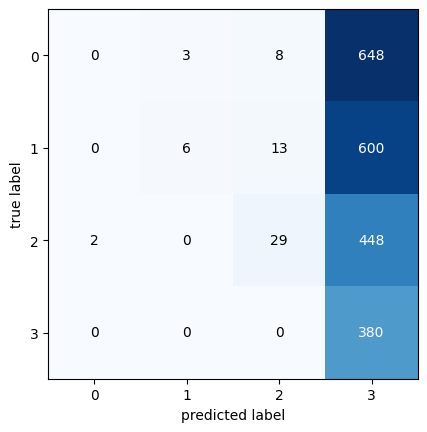

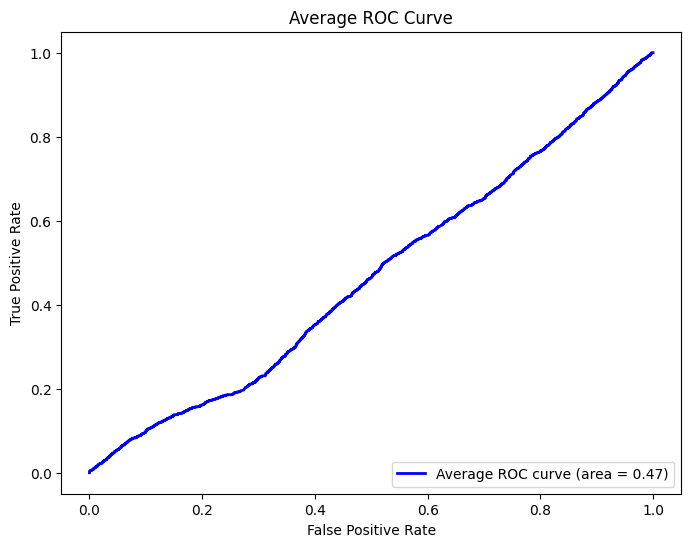

Test AUROC (roc_curve + auc): 0.46807535042827875
Test Loss: 2.9405806064605713, Test Accuracy: 0.1941974730931212
Test Precision: 0.3556591046999241, Test Recall: 0.1941974730931212, Test F2 Score: 0.1139820108905348


In [ ]:
model.eval()
model = model.to("cuda")
with torch.no_grad():
    # final_img = inputs_test['pixel_values'].to("cuda")
    # final_label = inputs_test['label'].to("cuda")

    # Ensure inputs are tensors
    final_img = torch.tensor(inputs_test['pixel_values']).to("cuda")
    final_label = torch.tensor(inputs_test['label']).to("cuda")

    logits = model(final_img).logits

    loss = criterion(logits, final_label)

    logits = logits.to("cpu")
    predicted_labels = torch.argmax(logits, axis=1)
    cm = confusion_matrix(inputs_test['label'],predicted_labels)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    fig.show()

    # Convert labels to one-hot
    test_label_one_hot = label_binarize(inputs_test['label'], classes=[i for i in range(logits.shape[1])])

    n_classes = logits.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # test_auroc = roc_auc_score(test_label_one_hot, logits, multi_class='ovr')
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(test_label_one_hot[:, i], logits[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute average ROC curve and ROC area
    fpr_avg, tpr_avg, _ = roc_curve(test_label_one_hot.ravel(), logits.ravel())
    roc_auc_avg = auc(fpr_avg, tpr_avg)

    # Plot the average ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc_avg)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    test_acc = accuracy_score(inputs_test['label'], predicted_labels)
    test_loss = loss.item()
    test_precision = precision_score(inputs_test['label'], predicted_labels, average='weighted')
    test_recall = recall_score(inputs_test['label'], predicted_labels, average='weighted')
    test_f2_score = fbeta_score(inputs_test['label'], predicted_labels, beta=2, average='weighted')

    print(f"Test AUROC (roc_curve + auc): {roc_auc_avg}")
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
    print(f"Test Precision: {test_precision}, Test Recall: {test_recall}, Test F2 Score: {test_f2_score}")

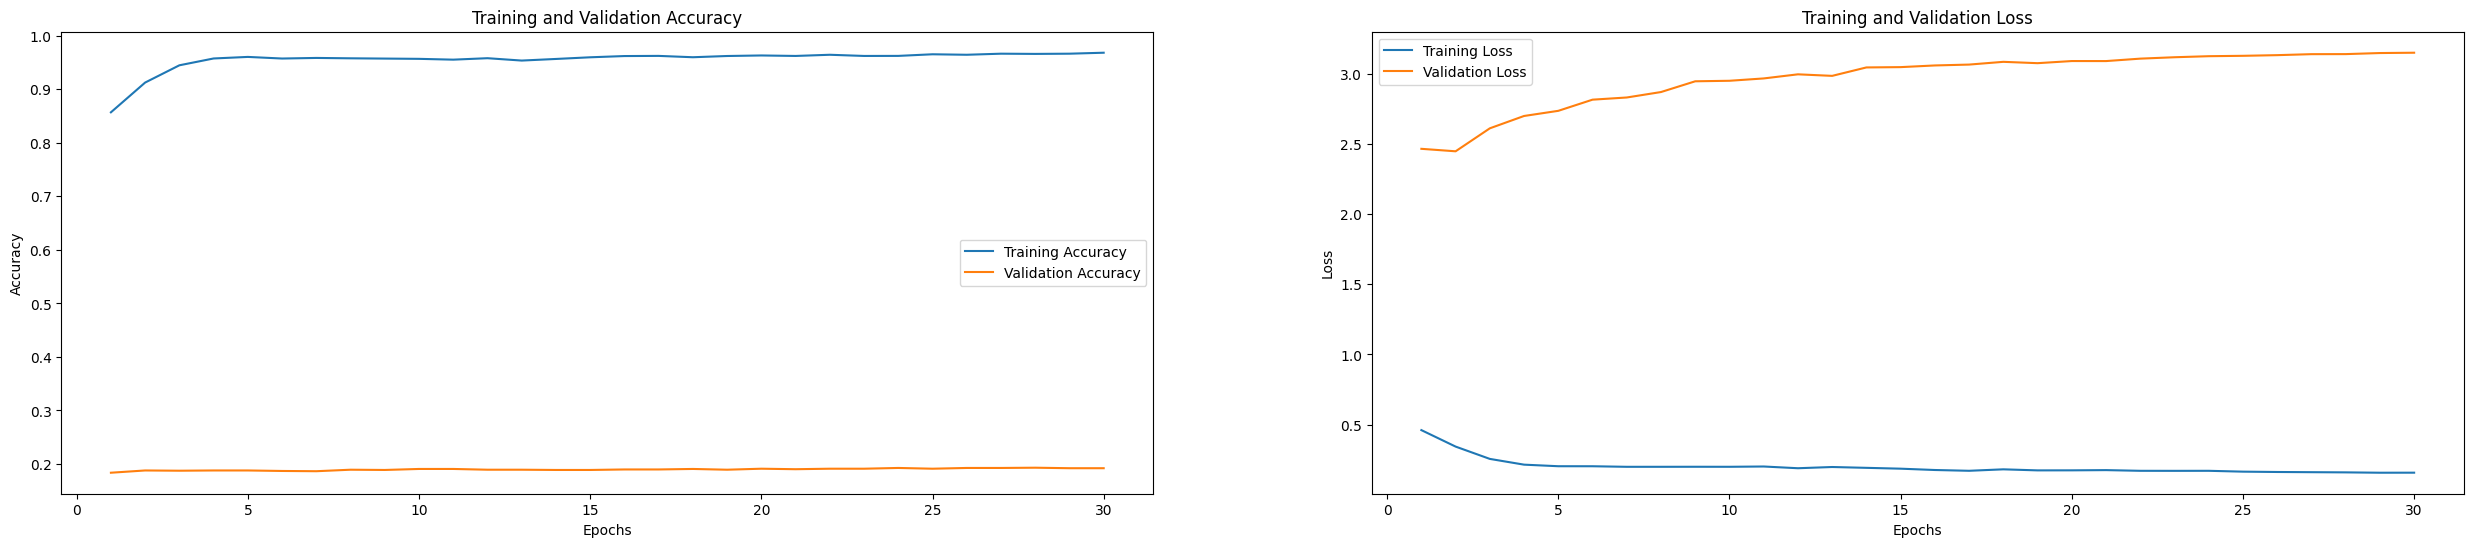

In [ ]:
import matplotlib.pyplot as plt

# Extracted data from your logs
epochs = list(range(1, 31))
train_losses = [
    0.46160565536192444, 0.3443249580611187, 0.2566674217581749, 0.21574842978164135, 0.20455981724592576,
    0.20437768438165207, 0.20040506304327743, 0.20044614559406018, 0.2007188156277061, 0.20054086193621876,
    0.20261442521848833, 0.19029437995040752, 0.19898027785451536, 0.19308831635638174, 0.18707370760749623,
    0.17764610569161104, 0.17208483934326462, 0.18246076700133163, 0.17496012163545622, 0.1752913120567376,
    0.17686894727592267, 0.17196275071633237, 0.17166137228828337, 0.17196275071633237, 0.16594634504357953,
    0.16352634849948456, 0.16212632238742394, 0.16082312041356365, 0.15832071743205248, 0.15862051867154786
]

val_losses = [
    2.463904857635498, 2.446274757385254, 2.609869956970215, 2.6977241039276123, 2.7343599796295166,
    2.813800811767578, 2.8293051719665527, 2.868077039718628, 2.944589138031006, 2.9482581615448,
    2.9649147987365723, 2.9941749572753906, 2.983222246170044, 3.0432324409484863, 3.0454304218292236,
    3.0573465824127197, 3.063535690307617, 3.083098888397217, 3.0735442638397217, 3.08868670463562,
    3.0884945392608643, 3.1058475971221924, 3.115760564804077, 3.12321400642395, 3.1259379386901855,
    3.1306583881378174, 3.13767671585083, 3.1380650997161865, 3.1456611156463623, 3.147958517074585
]

train_accuracies = [
    0.8570281124497992, 0.9126506024096386, 0.9448795180722892, 0.9576305220883534, 0.9605421686746988,
    0.9575301204819278, 0.9586345381526105, 0.9579317269076305, 0.957429718875502, 0.9569277108433735,
    0.9554216867469879, 0.9581325301204819, 0.953714859437751, 0.956726907630522, 0.9598393574297188,
    0.96214859437751, 0.962448995338255, 0.9599397590361446, 0.962247191011236, 0.9632512062726176,
    0.9623477915488998, 0.9645566265060241, 0.9623477915488998, 0.962448995338255, 0.9654598373286644,
    0.9645574297188755, 0.9665646551724138, 0.9661634579205937, 0.9665646551724138, 0.9683729757225504
]

val_accuracies = [
    0.1836925960637301, 0.18791002811621368, 0.18744142455482662, 0.18791002811621368, 0.18791002811621368,
    0.18697282099343954, 0.18650421743205248, 0.1893158388003749, 0.1888472352389878, 0.19072164948453607,
    0.19072164948453607, 0.1893158388003749, 0.1893158388003749, 0.1888472352389878, 0.1888472352389878,
    0.18978444236176195, 0.18978444236176195, 0.19072164948453607, 0.1893158388003749, 0.19118925304592313,
    0.19025304592314903, 0.19118925304592313, 0.19118925304592313, 0.19259506373008323, 0.19118925304592313,
    0.19259506373008323, 0.19259506373008323, 0.1930626672914703, 0.19212646016869617, 0.19212646016869617
]

# Plotting the data
fig, axs = plt.subplots(1, 2, figsize=(31, 6))

# Plotting accuracy
axs[0].plot(epochs, train_accuracies, label='Training Accuracy')
axs[0].plot(epochs, val_accuracies, label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(False)

# Plotting loss
axs[1].plot(epochs, train_losses, label='Training Loss')
axs[1].plot(epochs, val_losses, label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(False)

plt.show()


In [ ]:
fpr

{0: array([0.00000000e+00, 6.76589986e-04, 2.02976996e-03, 2.02976996e-03,
        2.70635995e-03, 2.70635995e-03, 4.73612991e-03, 4.73612991e-03,
        6.76589986e-03, 6.76589986e-03, 8.79566982e-03, 8.79566982e-03,
        9.47225981e-03, 9.47225981e-03, 1.01488498e-02, 1.01488498e-02,
        1.08254398e-02, 1.08254398e-02, 1.28552097e-02, 1.28552097e-02,
        1.48849797e-02, 1.48849797e-02, 1.55615697e-02, 1.55615697e-02,
        1.75913396e-02, 1.75913396e-02, 1.82679296e-02, 1.82679296e-02,
        1.89445196e-02, 1.89445196e-02, 1.96211096e-02, 1.96211096e-02,
        2.09742896e-02, 2.09742896e-02, 2.36806495e-02, 2.36806495e-02,
        3.04465494e-02, 3.04465494e-02, 3.17997294e-02, 3.17997294e-02,
        3.31529093e-02, 3.31529093e-02, 4.73612991e-02, 4.73612991e-02,
        4.80378890e-02, 4.80378890e-02, 4.87144790e-02, 4.87144790e-02,
        5.07442490e-02, 5.07442490e-02, 5.48037889e-02, 5.48037889e-02,
        5.68335589e-02, 5.68335589e-02, 5.75101488e-02, 5.751

In [ ]:
tpr

{0: array([0.        , 0.        , 0.        , 0.00151745, 0.00151745,
        0.0030349 , 0.0030349 , 0.00455235, 0.00455235, 0.0060698 ,
        0.0060698 , 0.0091047 , 0.0091047 , 0.01062215, 0.01062215,
        0.01213961, 0.01213961, 0.01365706, 0.01365706, 0.01669196,
        0.01669196, 0.01972686, 0.01972686, 0.02124431, 0.02124431,
        0.02427921, 0.02427921, 0.02579666, 0.02579666, 0.02731411,
        0.02731411, 0.03034901, 0.03034901, 0.03186646, 0.03186646,
        0.03338392, 0.03338392, 0.03641882, 0.03641882, 0.03793627,
        0.03793627, 0.04248862, 0.04248862, 0.04855842, 0.04855842,
        0.05007587, 0.05007587, 0.06069803, 0.06069803, 0.06221548,
        0.06221548, 0.06373293, 0.06373293, 0.06525038, 0.06525038,
        0.06980273, 0.06980273, 0.07132018, 0.07132018, 0.07283763,
        0.07283763, 0.07435508, 0.07435508, 0.07587253, 0.07587253,
        0.07890744, 0.07890744, 0.08042489, 0.08042489, 0.08345979,
        0.08345979, 0.08497724, 0.08497724, 0

In [ ]:
roc_auc

{0: 0.5300512729953327,
 1: 0.5096142999142227,
 2: 0.5316753590486816,
 3: 0.6236003355001049}

In [ ]:
# roc_auc_score(test_label_one_hot,logits, multi_class='ovr')

In [ ]:
# accuracy_score(inputs_test['label'], predicted_labels)

In [ ]:
# len(inputs_test['label'])